# Project TravelTide

## Introduction
TravelTide is a project aimed at analyzing customer sessions, bookings, and behaviors to understand key trends, preferences, and customer segmentation. The primary goal is to derive actionable insights for improved marketing, personalized offers, and increased customer satisfaction.

### Goals of the Project
- Analyze customer sessions, bookings, and purchasing behaviors.
- Segment customers using RFM (Recency, Frequency, Monetary) analysis and K-Means clustering.
- Provide suggestions for targeted marketing and personalized perks based on segmentation.

In [ ]:
# Install the necessary libraries
!pip install psycopg2 pandas

import psycopg2
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Establishing a connection to PostgreSQL
conn = psycopg2.connect(
    dbname="TravelTide",  # название базы данных
    user="Test",  # пользователь
    password="bQNxVzJL4g6u",  # пароль
    host="ep-noisy-flower-846766.us-east-2.aws.neon.tech",  # хост базы данных
    port="5432"  # порт по умолчанию для PostgreSQL
)

# Request to get data
query = """
WITH session_based AS (
    SELECT
        s.session_id,
        s.user_id,
        s.trip_id,
        s.session_start,
        s.session_end,
        s.page_clicks,
        s.flight_discount,
        s.flight_discount_amount,
        s.hotel_discount,
        s.hotel_discount_amount,
        s.flight_booked,
        s.hotel_booked,
        s.cancellation,
        EXTRACT(EPOCH FROM (s.session_end - s.session_start)) AS session_duration,
        f.trip_id,
        f.origin_airport,
        f.destination,
        f.destination_airport,
        f.seats,
        f.return_flight_booked,
        f.departure_time,
        f.return_time,
        f.checked_bags,
        f.trip_airline,
        f.destination_airport_lat,
        f.destination_airport_lon,
        f.base_fare_usd,
        h.trip_id,
        h.hotel_name,
        h.nights,
        h.rooms,
        h.check_in_time,
        h.check_out_time,
        h.hotel_per_room_usd AS hotel_price_per_room_night_usd,
        u.birthdate,
        u.gender,
        u.married,
        u.has_children,
        u.home_country,
        u.home_city,
        u.home_airport,
        u.home_airport_lat,
  			u.home_airport_lon,
        u.sign_up_date
  from sessions s
  left join users u
  on s.user_id = u.user_id
  left join flights f
  on s.trip_id = f.trip_id
  left join hotels h
  on s.trip_id = h.trip_id
  WHERE s.user_id IN (SELECT user_id
                     FROM sessions
                     WHERE session_start > '2023-01-04'
                     GROUP BY user_id
                     HAVING COUNT(*) > 7)

)
SELECT *
FROM session_based;
"""

# Loading data into a DataFrame
df = pd.read_sql(query, conn)

# Closing the connection
conn.close()

# Let's check what the data looks like
df.head()

<ipython-input-1-a80e57acd91b>:88: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,...,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date
0,518751-58953f6c91fe4991aea6b9dadd24ce71,518751,518751-d5522e6eff784dcb9702d712ec54e719,2023-01-19 10:29:00,2023-01-19 10:31:45,22,False,NaN,False,NaN,...,1991-01-17,F,False,False,usa,indianapolis,IND,39.717,-86.294,2023-01-09
1,187212-949ea991afb14d19a4474e2bc5081374,187212,None,2022-05-21 20:14:00,2022-05-21 20:18:44,39,False,NaN,False,NaN,...,1969-02-20,F,True,True,usa,los angeles,LAX,33.942,-118.408,2022-05-21
2,187212-6616a1bda1354862a425ba32f9ceb3b9,187212,None,2022-06-01 22:39:00,2022-06-01 22:40:09,9,False,NaN,False,NaN,...,1969-02-20,F,True,True,usa,los angeles,LAX,33.942,-118.408,2022-05-21
3,187212-aa4fd49b8dd14f52b3925c9fea27f24f,187212,None,2022-06-16 17:22:00,2022-06-16 17:22:52,7,True,0.05,True,0.25,...,1969-02-20,F,True,True,usa,los angeles,LAX,33.942,-118.408,2022-05-21
4,187212-6160f7a6e2174960ae187e3e2699bbba,187212,None,2022-07-22 11:46:00,2022-07-22 11:46:31,4,False,NaN,True,0.05,...,1969-02-20,F,True,True,usa,los angeles,LAX,33.942,-118.408,2022-05-21


In [ ]:
# Adding age column
current_year = datetime.now().year
df_unique['age'] = current_year - pd.to_datetime(df_unique['birthdate']).dt.year

# Assigning user groups
df_unique['user_group'] = None

# Families: married and have children
df_unique.loc[
    (df_unique['user_group'].isna()) &
    (df_unique['married'] == True) &
    (df_unique['has_children'] == True),
    'user_group'
] = 'Families'

# Business Travelers: short trips up to 3 days and only one seat booked
df_unique.loc[
    (df_unique['user_group'].isna()) &
    (df_unique['nights'] <= 3) &
    (df_unique['seats'] == 1),
    'user_group'
] = 'Business Travelers'

# Seniors: users older than 60 years
df_unique.loc[
    (df_unique['user_group'].isna()) &
    (df_unique['age'] > 60),
    'user_group'
] = 'Seniors'

# Childless Couples: married and no children
df_unique.loc[
    (df_unique['user_group'].isna()) &
    (df_unique['married'] == True) &
    (df_unique['has_children'] == False),
    'user_group'
] = 'Childless Couples'

# Solo Travelers: travel alone and are not married
df_unique.loc[
    (df_unique['user_group'].isna()) &
    (df_unique['married'] == False),
    'user_group'
] = 'Solo Travelers'

# Assigning "Other" to users who don't fit any group
df_unique.loc[df_unique['user_group'].isna(), 'user_group'] = 'Other'

# Counting users in each group
group_counts = df_unique['user_group'].value_counts().to_dict()
print("\nUser Group Counts:")
print(group_counts)



User Group Counts:
{'Solo Travelers': 3185, 'Childless Couples': 1290, 'Families': 1084, 'Seniors': 291, 'Business Travelers': 148}


<ipython-input-14-b7fec4ca1ba5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['age'] = current_year - pd.to_datetime(df_unique['birthdate']).dt.year
<ipython-input-14-b7fec4ca1ba5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['user_group'] = None


<ipython-input-57-7a7ed7a9b60a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['age'] = current_year - pd.to_datetime(df_unique['birthdate']).dt.year
<ipython-input-57-7a7ed7a9b60a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['user_group'] = None



User Group Counts:
{'Solo Travelers': 3185, 'Childless Couples': 1290, 'Families': 1084, 'Seniors': 291, 'Business Travelers': 148}


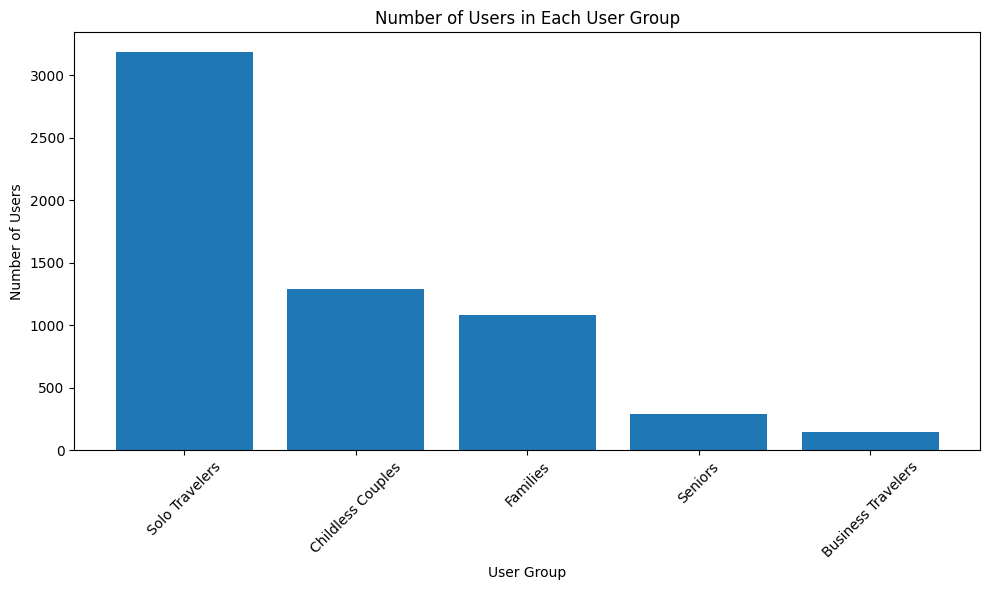

In [ ]:
# Adding age column
current_year = datetime.now().year
df_unique['age'] = current_year - pd.to_datetime(df_unique['birthdate']).dt.year

# Assigning user groups
df_unique['user_group'] = None

# Families: married and have children
df_unique.loc[
    (df_unique['user_group'].isna()) &
    (df_unique['married'] == True) &
    (df_unique['has_children'] == True),
    'user_group'
] = 'Families'

# Business Travelers: short trips up to 3 days and only one seat booked
df_unique.loc[
    (df_unique['user_group'].isna()) &
    (df_unique['nights'] <= 3) &
    (df_unique['seats'] == 1),
    'user_group'
] = 'Business Travelers'

# Seniors: users older than 60 years
df_unique.loc[
    (df_unique['user_group'].isna()) &
    (df_unique['age'] > 60),
    'user_group'
] = 'Seniors'

# Childless Couples: married and no children
df_unique.loc[
    (df_unique['user_group'].isna()) &
    (df_unique['married'] == True) &
    (df_unique['has_children'] == False),
    'user_group'
] = 'Childless Couples'

# Solo Travelers: travel alone and are not married
df_unique.loc[
    (df_unique['user_group'].isna()) &
    (df_unique['married'] == False),
    'user_group'
] = 'Solo Travelers'

# Assigning "Other" to users who don't fit any group
df_unique.loc[df_unique['user_group'].isna(), 'user_group'] = 'Other'

# Counting users in each group
group_counts = df_unique['user_group'].value_counts().to_dict()
print("\nUser Group Counts:")
print(group_counts)

# Plotting bar chart for user group counts

plt.figure(figsize=(10, 6))
plt.bar(group_counts.keys(), group_counts.values())
plt.xlabel('User Group')
plt.ylabel('Number of Users')
plt.title('Number of Users in Each User Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().set_facecolor('none')  # Set transparent background
plt.savefig('user_group_counts.png', transparent=True)
plt.show()



1. **Solo Travelers**: The largest group consists of *Solo Travelers*, with 3185 users. This indicates that a significant portion of users prefers to travel alone.

2. **Childless Couples**: There are 1290 users in the *Childless Couples* category, representing the second-largest group. This shows a substantial number of users who are married but do not have children, possibly indicating a preference for flexibility in travel plans without the constraints that come with family responsibilities.

3. **Families**: *Families* make up 1084 users, suggesting a considerable number of family trips. This could imply that family-oriented travel services, such as larger accommodations and family-friendly activities, might be in demand.

4. **Seniors**: The *Seniors* group, with 291 users, represents those aged over 60. This group might prefer specific amenities like increased comfort and assistance during travel.

5. **Business Travelers**: With 148 users, *Business Travelers* are the smallest group. These are users who travel alone on short trips (up to 3 days). The relatively small size of this group may suggest that short-term business trips are less common compared to other types of travel.

In [ ]:
# Adding a column for the number of bookings (sum of flight and hotel bookings)
df_unique['total_bookings'] = df_unique['flight_booked'] + df_unique['hotel_booked']

# Creating an empty DataFrame to store the top users from each group
top_users = pd.DataFrame()

# Iterating through each user group and selecting the user with the highest number of bookings
for group in df_unique['user_group'].unique():
    top_user = df_unique[df_unique['user_group'] == group].sort_values(by='total_bookings', ascending=False).head(1)
    top_users = pd.concat([top_users, top_user])

# Resetting index for better readability
top_users.reset_index(drop=True, inplace=True)

# Displaying the top users from each group
print(top_users)

# to Excel
top_users.to_excel('top_users_per_group.xlsx', index=False, engine='openpyxl')


                                session_id  user_id  \
0  518751-58953f6c91fe4991aea6b9dadd24ce71   518751   
1  513236-3bf1ca20d253438c97f577864f63bdcf   513236   
2  509115-5cf62f0a60c940fc8a8e389491e054a1   509115   
3  485544-9937428cf80c40f187c77610c67683d5   485544   
4  460181-fe512a90106e493cb3056b260562c733   460181   

                                   trip_id       session_start  \
0  518751-d5522e6eff784dcb9702d712ec54e719 2023-01-19 10:29:00   
1  513236-a9d130334a1e495e9e14d4e86ccee08f 2023-04-15 19:34:00   
2  509115-70ac238540504605a01711e2e2446d67 2023-02-06 11:06:00   
3  485544-53a0590c4fdf4e86a40611f43d5dd745 2022-12-23 12:29:00   
4  460181-f70f1e7c50484fce828c22db9a13f34e 2023-01-21 06:05:00   

          session_end  page_clicks  flight_discount  flight_discount_amount  \
0 2023-01-19 10:31:45           22            False                     NaN   
1 2023-04-15 19:37:06           25            False                     NaN   
2 2023-02-06 11:07:45           14 

<ipython-input-54-fe928fd4c0bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['total_bookings'] = df_unique['flight_booked'] + df_unique['hotel_booked']


<ipython-input-63-b4df3f8f7415>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Average Clicks': flight_discount_avg_clicks.get(0, 0)
<ipython-input-63-b4df3f8f7415>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Average Clicks': flight_discount_avg_clicks.get(1, 0)
<ipython-input-63-b4df3f8f7415>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Average Clicks': hotel_discount_avg_clicks.get(0, 0)
<ipython-input-63-b4df3f8f

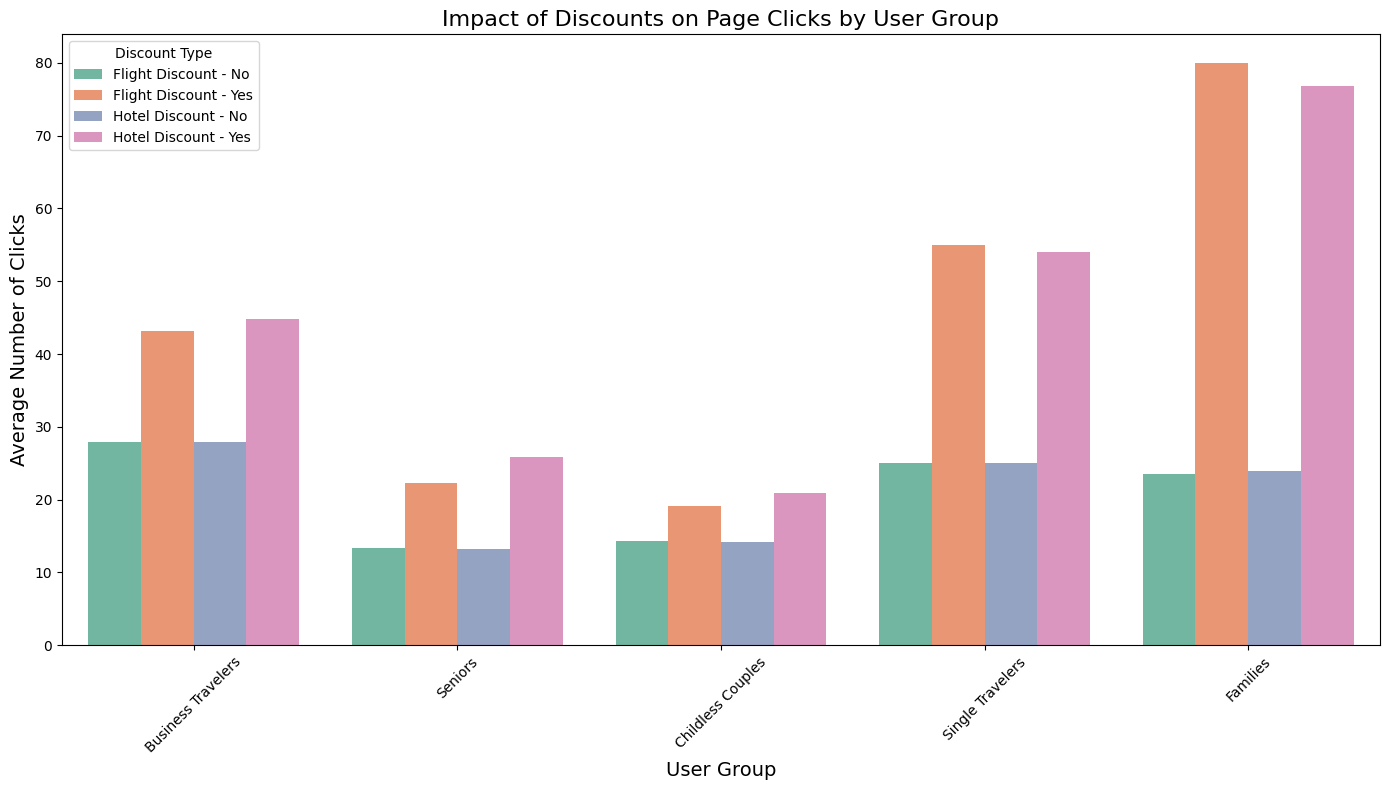

In [ ]:
# Prepare data for the bar plot
group_discounts = []

# Loop through each group and calculate the impact of discounts
for group in user_groups:
    group_df = df[df['user_group'] == group]

    # Calculate average page clicks with and without flight discounts
    flight_discount_avg_clicks = group_df.groupby('flight_discount')['page_clicks'].mean()
    group_discounts.append({
        'User Group': group,
        'Discount Type': 'Flight Discount - No',
        'Average Clicks': flight_discount_avg_clicks.get(0, 0)
    })
    group_discounts.append({
        'User Group': group,
        'Discount Type': 'Flight Discount - Yes',
        'Average Clicks': flight_discount_avg_clicks.get(1, 0)
    })

    # Calculate average page clicks with and without hotel discounts
    hotel_discount_avg_clicks = group_df.groupby('hotel_discount')['page_clicks'].mean()
    group_discounts.append({
        'User Group': group,
        'Discount Type': 'Hotel Discount - No',
        'Average Clicks': hotel_discount_avg_clicks.get(0, 0)
    })
    group_discounts.append({
        'User Group': group,
        'Discount Type': 'Hotel Discount - Yes',
        'Average Clicks': hotel_discount_avg_clicks.get(1, 0)
    })

# Convert to DataFrame for easier plotting
discount_df = pd.DataFrame(group_discounts)


# Plotting a bar plot to compare the impact of discounts across all user groups
plt.figure(figsize=(14, 8))
sns.barplot(
    data=discount_df,
    x='User Group',
    y='Average Clicks',
    hue='Discount Type',
    palette='Set2'
)
plt.title("Impact of Discounts on Page Clicks by User Group", fontsize=16)
plt.xlabel("User Group", fontsize=14)
plt.ylabel("Average Number of Clicks", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Discount Type")
plt.tight_layout()
plt.show()

Looking at the provided bar chart, we can make the following observations regarding the impact of discounts on page clicks for different user groups:

1. **Families and Solo Travelers**: These two groups show the highest response to both types of discounts, with both flight and hotel discounts leading to a significant increase in the average number of clicks. Discounts are particularly effective for these groups, indicating a high sensitivity to price reductions.

2. **Business Travelers**: The *Business Travelers* group responds better to flight discounts compared to hotel discounts, but overall their click rates are lower than families and solo travelers. This suggests that while discounts are influential, the effect is not as pronounced, perhaps due to the necessity-driven nature of business trips.

3. **Seniors and Childless Couples**: These groups have moderate click responses compared to others. Hotel discounts seem to be particularly effective for *Childless Couples*, while *Seniors* show a balanced but generally lower response to both discount types.

4. **No Discounts vs Discounts**: Across the board, having no discounts results in fewer clicks, while having discounts (either for flights or hotels) increases user activity, reinforcing the importance of price-based promotions to drive engagement.

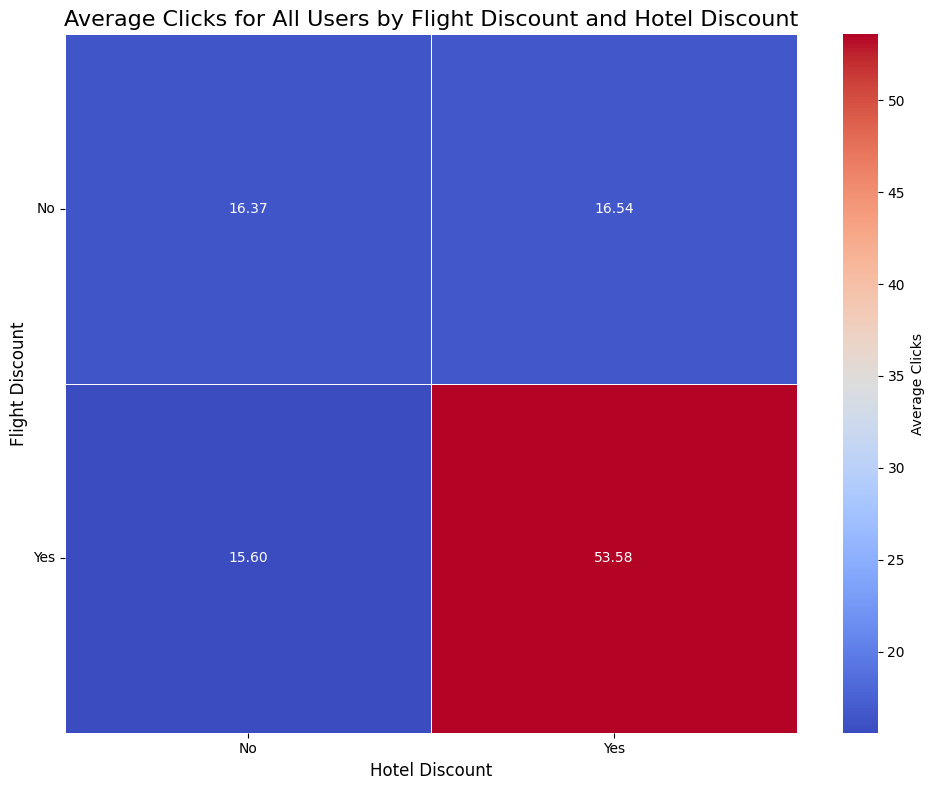

In [ ]:
# Prepare data for the heatmap including all users without separating by group
all_users_data = df.groupby(['flight_discount', 'hotel_discount'])['page_clicks'].mean().reset_index()

# Pivot the data to create a matrix for the heatmap
heatmap_pivot_all_users = all_users_data.pivot(index='flight_discount', columns='hotel_discount', values='page_clicks')

# Plotting the combined heatmap for all users
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_pivot_all_users,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Average Clicks'}
)
plt.title("Average Clicks for All Users by Flight Discount and Hotel Discount", fontsize=16)
plt.xlabel("Hotel Discount", fontsize=12)
plt.ylabel("Flight Discount", fontsize=12)
plt.xticks(ticks=[0.5, 1.5], labels=["No", "Yes"])
plt.yticks(ticks=[0.5, 1.5], labels=["No", "Yes"], rotation=0)
plt.tight_layout()
plt.show()


<ipython-input-27-5624fce06102>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_vs_booking = df.groupby('session_category')['flight_booked'].mean()
<ipython-input-27-5624fce06102>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=session_vs_booking.index, y=session_vs_booking.values, palette="viridis")


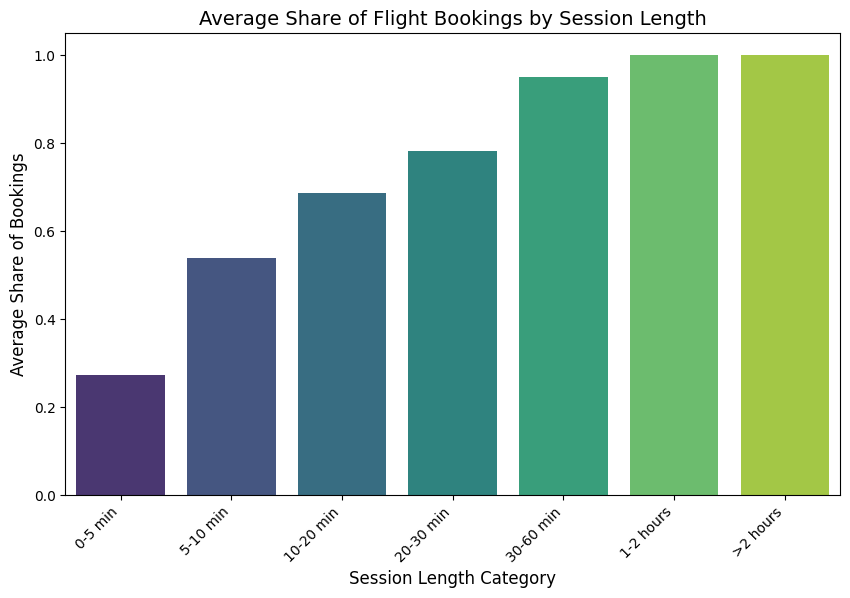

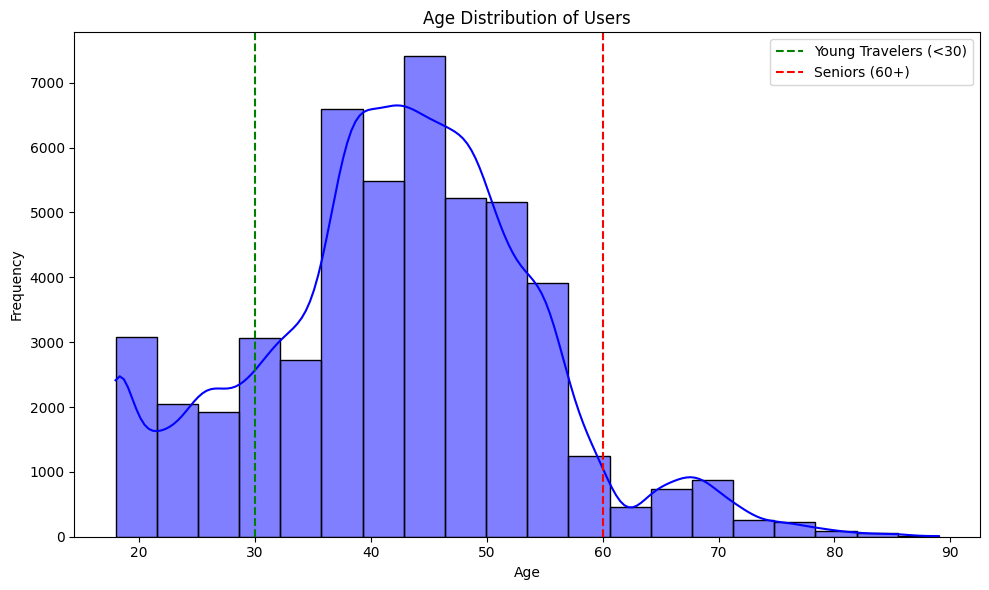

In [ ]:
# Session Length vs Bookings without separating by User Group
bins = [0, 300, 600, 1200, 1800, 3600, 7200, 10000]  # Session length ranges in seconds
labels = ["0-5 min", "5-10 min", "10-20 min", "20-30 min", "30-60 min", "1-2 hours", ">2 hours"]
df['session_category'] = pd.cut(df['session_duration'], bins=bins, labels=labels, right=False)

# Calculate average flight bookings for each session length category
session_vs_booking = df.groupby('session_category')['flight_booked'].mean()

# Plotting session length vs bookings for all users combined
plt.figure(figsize=(10, 6))
sns.barplot(x=session_vs_booking.index, y=session_vs_booking.values, palette="viridis")
plt.title("Average Share of Flight Bookings by Session Length", fontsize=14)
plt.xlabel("Session Length Category", fontsize=12)
plt.ylabel("Average Share of Bookings", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# Age group distribution visualization with vertical lines indicating user group boundaries
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True, color='blue')

# Adding vertical lines to indicate age boundaries for user groups
plt.axvline(x=30, color='green', linestyle='--', label='Young Travelers (<30)')
plt.axvline(x=60, color='red', linestyle='--', label='Seniors (60+)')

plt.title("Age Distribution of Users")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


### 1. **Age Distribution of Users**:
- **Young users (under 30)** make up a significant part of the audience, as indicated by the high frequency in this age group.
- **Senior users (over 60)** represent a smaller segment, with a notable drop in frequency after this age.
- The majority of users fall within the **30-60 age range**, indicating a strong base of middle-aged users.

### 2. **Average Flight Bookings by Session Length**:
- Longer sessions correlate with a higher likelihood of booking flights.
- Users with sessions of **10-20 minutes or longer** are more likely to make a booking.
- The highest booking rates are seen for sessions between **30 minutes to over 2 hours**, suggesting that longer engagement leads to more bookings.


   age_group  has_children  user_count    group_type
0      18-35         False         514   only_hotels
1      18-35          True         216   only_hotels
2      36-55         False         904   only_hotels
3      36-55          True         526   only_hotels
4        55+         False         251   only_hotels
5        55+          True          84   only_hotels
6      18-35         False         253  only_flights
7      18-35          True          96  only_flights
8      36-55         False         944  only_flights
9      36-55          True         449  only_flights
10       55+         False          97  only_flights
11       55+          True          34  only_flights


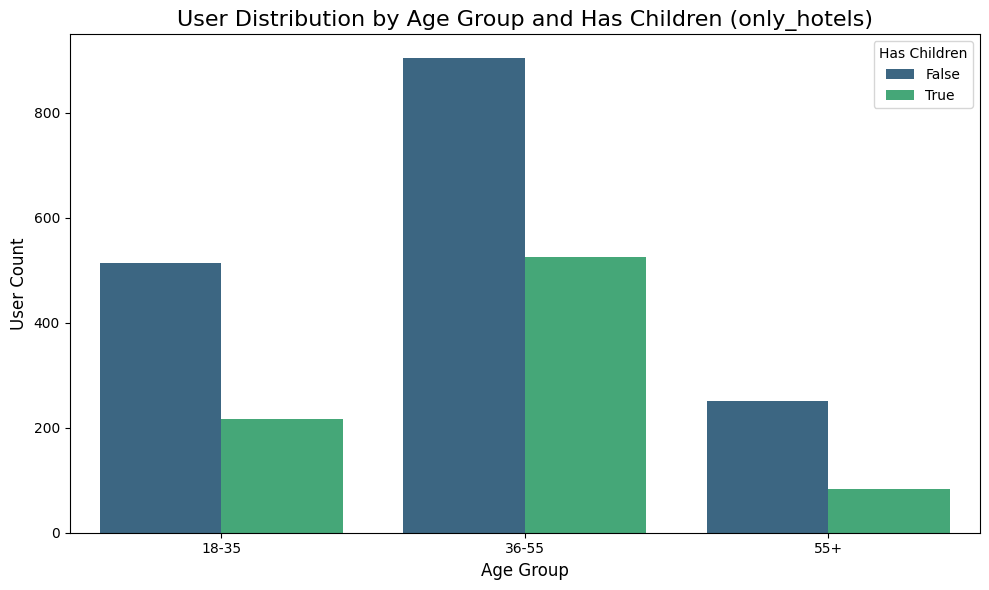

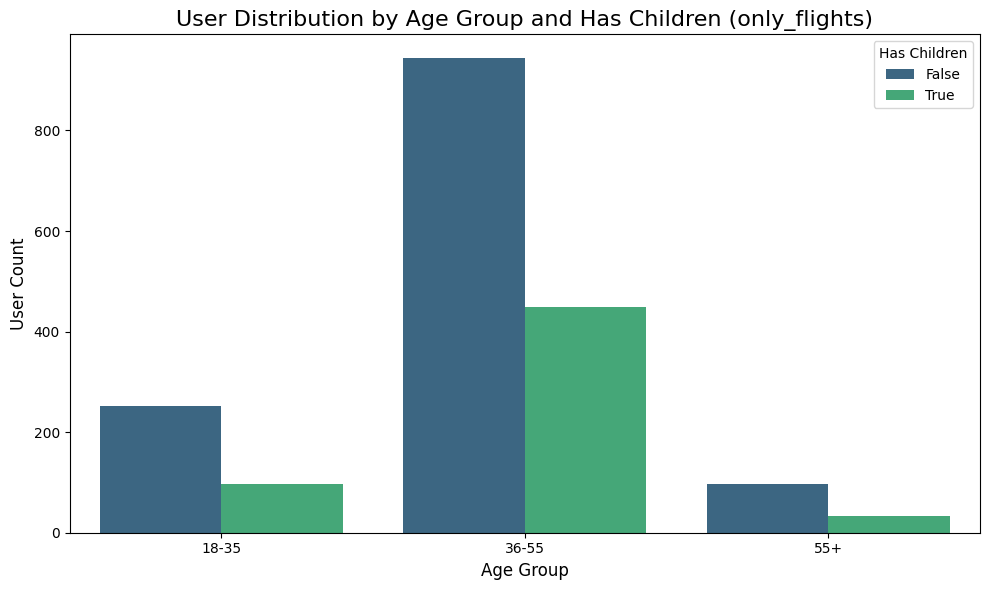

In [ ]:
# Ensure date of birth is in datetime format
df['birthdate'] = pd.to_datetime(df['birthdate'])

# Age calculation
df['age'] = (pd.Timestamp.now() - df['birthdate']).dt.days // 365

# Filtering data for only hotel or flight bookings
only_hotels = df[(df['hotel_booked'] == True) & (df['flight_booked'] == False)].copy()
only_flights = df[(df['flight_booked'] == True) & (df['hotel_booked'] == False)].copy()

# Function for classifying age groups
def classify_age_group(age):
    if 18 <= age <= 35:
        return '18-35'
    elif 36 <= age <= 55:
        return '36-55'
    else:
        return '55+'

# Applying the function to classify age groups
only_hotels['age_group'] = only_hotels['age'].apply(classify_age_group)
only_flights['age_group'] = only_flights['age'].apply(classify_age_group)

# Counting the number of users in each group
hotels_grouped = only_hotels.groupby(['age_group', 'has_children']).size().reset_index(name='user_count')
hotels_grouped['group_type'] = 'only_hotels'

flights_grouped = only_flights.groupby(['age_group', 'has_children']).size().reset_index(name='user_count')
flights_grouped['group_type'] = 'only_flights'

# Combining the results
result = pd.concat([hotels_grouped, flights_grouped], ignore_index=True)

# Output of results
print(result)

# Function to visualize age group distribution
def plot_age_group_distribution(data, group_type):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=data,
        x='age_group',
        y='user_count',
        hue='has_children',
        palette='viridis'
    )
    plt.title(f"User Distribution by Age Group and Has Children ({group_type})", fontsize=16)
    plt.xlabel("Age Group", fontsize=12)
    plt.ylabel("User Count", fontsize=12)
    plt.legend(title="Has Children", loc='upper right')
    plt.tight_layout()
    plt.show()

# Creating separate graphs for only_hotels and only_flights
for group_type in result['group_type'].unique():
    subset = result[result['group_type'] == group_type]
    plot_age_group_distribution(subset, group_type)


### Insights from the graphs:

1. **Distribution of users who booked only hotels**:
- Most of the users who booked only hotels are in the **36-55** age group.
- There is a large number of users in this age group who **have children**, suggesting that this group is more focused on family travel and comfortable accommodations.
- There is also a significant number of users in the **18-35** age group, but mostly **without children**. This may mean that younger users are more likely to travel alone or in couples.

2. **Distribution of users who booked only flights**:
- Similar to hotel only bookings, most of the users in the **36-55** age group also have children, but the overall number of users here is lower compared to hotel only bookings.
- In the **18-35** age group, the majority of users are **without children**, which matches the typical profile of a younger traveler who tends to choose flights, perhaps for shorter, less burdensome trips.

### Key findings:
- The **36-55** age group with children is the dominant group for booking **hotels only**, suggesting that these users value comfort and convenience for family vacations.
- **Younger users (18-35)** without children tend to book **flights only**, suggesting that they prefer to save on accommodation or do not require hotel accommodation.
- This can help with more effective targeting - for example, marketing offers to the **36-55** age group with children could include hotel packages, while for **18-35** it is preferable to focus on affordable flights and adventure tours.

In [ ]:
# Calculate the proportion of orders with a discount (discount_flight_proportion) for each user
df["flight_discount_used"] = np.where(df["flight_discount"] > 0, 1, 0)  # 1, if there was a discount
flight_discount_proportion = df.groupby("user_id")["flight_discount_used"].mean().reset_index()
flight_discount_proportion.rename(columns={"flight_discount_used": "discount_flight_proportion"}, inplace=True)

# Calculate the average flight discount for each user
average_flight_discount = df.groupby("user_id")["flight_discount_amount"].mean().reset_index()
average_flight_discount.rename(columns={"flight_discount_amount": "average_flight_discount"}, inplace=True)

# Scaling the session_duration indicator using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df["scaled_ADS_per_km"] = scaler.fit_transform(df[["session_duration"]])

# Combine metrics into one DataFrame
user_metrics = (
    flight_discount_proportion
    .merge(average_flight_discount, on="user_id", how="left")
    .merge(df.groupby("user_id")["scaled_ADS_per_km"].mean().reset_index(), on="user_id", how="left")
)

# Calculation of composite_score_weighted_sum
weights = [0.5, 0.3, 0.2]  # Setting weights
user_metrics["composite_score_weighted_sum"] = (
    user_metrics["discount_flight_proportion"] * weights[0] +
    user_metrics["average_flight_discount"] * weights[1] +
    user_metrics["scaled_ADS_per_km"] * weights[2]
)

# Replace inf and -inf with NaN and fill NaN with 0
user_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)
user_metrics.fillna(0, inplace=True)

# User Ranking
user_metrics["rank_weighted_sum"] = user_metrics["composite_score_weighted_sum"].rank(ascending=False).astype(int)

# Customer segmentation using np.select()
conditions_weighted = [
    user_metrics["rank_weighted_sum"] <= len(user_metrics) * 0.2,
    user_metrics["rank_weighted_sum"] <= len(user_metrics) * 0.6
]
choices = ["High Value", "Medium Value"]
user_metrics["segment_weighted_sum"] = np.select(conditions_weighted, choices, default="Low Value")

# Result output
print(user_metrics.head(10))
print(user_metrics.describe())

# Export the user_metrics DataFrame to a CSV file
user_metrics.to_csv('user_metrics.csv', index=False)  # Save the DataFrame as a CSV file


   user_id  discount_flight_proportion  average_flight_discount  \
0    23557                    0.166667                 0.150000   
1    94883                    0.083333                 0.100000   
2   101486                    0.384615                 0.075000   
3   101961                    0.250000                 0.133333   
4   106907                    0.142857                 0.150000   
5   118043                    0.307692                 0.166667   
6   120851                    0.384615                 0.175000   
7   125845                    0.230769                 0.150000   
8   133058                    0.076923                 0.150000   
9   149058                    0.166667                 0.050000   

   scaled_ADS_per_km  composite_score_weighted_sum  rank_weighted_sum  \
0           0.040281                      0.136390               2955   
1           0.007807                      0.073228               4656   
2           0.090845                      0

Correlation matrix of key metrics:
                 flight_discount  hotel_discount  page_clicks  flight_booked  \
flight_discount         1.000000        0.096992     0.128419      -0.001749   
hotel_discount          0.096992        1.000000     0.167319       0.049533   
page_clicks             0.128419        0.167319     1.000000       0.401604   
flight_booked          -0.001749        0.049533     0.401604       1.000000   
hotel_booked            0.006357        0.060185     0.404191       0.795523   

                 hotel_booked  
flight_discount      0.006357  
hotel_discount       0.060185  
page_clicks          0.404191  
flight_booked        0.795523  
hotel_booked         1.000000  


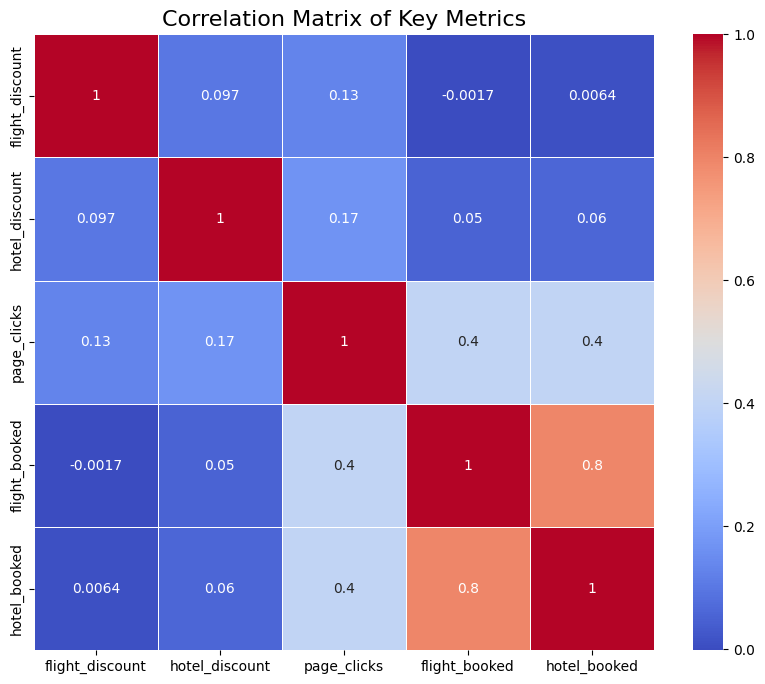

In [ ]:
# Correlation analysis between metrics
correlation_matrix = df[['flight_discount', 'hotel_discount', 'page_clicks', 'flight_booked', 'hotel_booked']].corr()
print("Correlation matrix of key metrics:")
print(correlation_matrix)

# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Key Metrics", fontsize=16)
plt.show()

**Summary of Findings from Correlation Matrix**:

1. **Weak Correlation between Discounts**:
   - The correlation between `flight_discount` and `hotel_discount` is **0.097**. This suggests that discounts on flights and hotels are not strongly related, meaning a discount on one does not imply a discount on the other.

2. **Impact of Discounts on Page Clicks**:
   - `page_clicks` has a weak positive correlation with both `flight_discount` (**0.128**) and `hotel_discount` (**0.167**). This indicates that discounts have some positive effect on user engagement, but it's not substantial.

3. **Flight and Hotel Bookings Correlation**:
   - `flight_booked` and `hotel_booked` have a high positive correlation of **0.796**, suggesting that users who book flights are also likely to book hotels. This implies a strong relationship between these types of bookings.

4. **Page Clicks and Bookings**:
   - `page_clicks` has a moderate correlation with both `flight_booked` (**0.402**) and `hotel_booked` (**0.404**). This suggests that increased engagement (more page clicks) is associated with higher booking rates, but it's not the only determining factor.

### Conclusion:
- **Flight and Hotel Discounts** have a limited direct effect on increasing engagement or driving bookings. More attractive offers or other marketing strategies may be needed to boost their effectiveness.
- **Flight and Hotel Bookings** are highly related, indicating that bundling these offerings or creating packages could be beneficial for increasing sales.
- **User Engagement (Page Clicks)** moderately affects bookings, suggesting that more interaction with the website leads to more bookings, but additional factors also play a role in decision-making.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Convert 'session_start' to datetime
df['session_start'] = pd.to_datetime(df['session_start'])

# Current date
current_date = datetime.now()

# Aggregate data by user_id
df_aggregated = df.groupby('user_id').agg(
    recency=('session_start', lambda x: (current_date - x.max()).days),  # Number of days since last session
    frequency=('session_id', 'count'),  # Number of sessions
    monetary=('flight_discount_amount', 'sum')  # Total of all discounts
).reset_index()

# Fill in the missing values ​​for Monetary and Recency
df_aggregated['monetary'] = df_aggregated['monetary'].fillna(0)
df_aggregated['recency'] = df_aggregated['recency'].fillna(df_aggregated['recency'].max())

# We rank users by each RFM parameter (from 1 to 5)
df_aggregated['R_score'] = pd.qcut(df_aggregated['recency'], 5, labels=[5, 4, 3, 2, 1])
df_aggregated['F_score'] = pd.cut(df_aggregated['frequency'], bins=5, labels=[1, 2, 3, 4, 5])
df_aggregated['M_score'] = pd.cut(df_aggregated['monetary'], bins=5, labels=[1, 2, 3, 4, 5])

# Combine RFM estimates into one line
df_aggregated['RFM'] = df_aggregated['R_score'].astype(str) + df_aggregated['F_score'].astype(str) + df_aggregated['M_score'].astype(str)

# Applying standardization to clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_aggregated[['recency', 'frequency', 'monetary']])

# Using K-Means for Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_aggregated['Cluster'] = kmeans.fit_predict(scaled_data)

# Segmenting customers
segments = {
    'Champions': df_aggregated[df_aggregated['RFM'] == '555'],
    'Loyal Customers': df_aggregated[df_aggregated['RFM'].str[1] == '5'],
    'At Risk': df_aggregated[(df_aggregated['RFM'].str[0] == '1') & (df_aggregated['RFM'].str[1:] != '11')],
    'Lost': df_aggregated[df_aggregated['RFM'] == '111']
}

# We display the results
print(df_aggregated[['user_id', 'RFM', 'Cluster']].head())
print(segments)


# Create an Excel file with multiple sheets
with pd.ExcelWriter('user_segments.xlsx', engine='openpyxl') as writer:
    df_aggregated.to_excel(writer, sheet_name='All Users', index=False)  # All users
    segments['Champions'].to_excel(writer, sheet_name='Champions', index=False)  # Champions
    segments['Loyal Customers'].to_excel(writer, sheet_name='Loyal Customers', index=False)  # Loyal Customers
    segments['At Risk'].to_excel(writer, sheet_name='At Risk', index=False)  # At Risk
    segments['Lost'].to_excel(writer, sheet_name='Lost', index=False)  # Lost

   user_id  RFM  Cluster
0    23557  541        2
1    94883  241        2
2   101486  552        2
3   101961  342        2
4   106907  551        2
{'Champions': Empty DataFrame
Columns: [user_id, recency, frequency, monetary, R_score, F_score, M_score, RFM, Cluster]
Index: [], 'Loyal Customers':      user_id  recency  frequency  monetary R_score F_score M_score  RFM  \
2     101486      502         13      0.30       5       5       2  552   
4     106907      493         14      0.15       5       5       1  551   
5     118043      505         13      0.50       5       5       3  553   
6     120851      538         13      0.70       2       5       3  253   
7     125845      500         13      0.30       5       5       2  552   
8     133058      503         13      0.15       5       5       1  551   
14    167852      585         13      0.30       1       5       2  152   
17    175032      499         14      0.30       5       5       2  552   
23    195192      552    

### **Customer Segments**:
1. **Champions**: This segment is empty, indicating that there are no users who scored the highest on each RFM parameter (high frequency, low recency, and high monetary value). This may imply a gap in achieving highly engaged and loyal customers.

2. **Loyal Customers**: This segment includes users with high frequency (`F_score` = `5`), indicating they are loyal to the company. There are 16 users in this segment, suggesting a group of highly active users. The recency values vary, showing that while they have interacted frequently, the time since their last interaction differs.

3. **At Risk**: These users have high recency scores (`R_score` = `1`), indicating they have not interacted with the product recently. There are 486 users in this segment, which shows a significant number of customers who might be at risk of churn. It's essential to create targeted campaigns to re-engage them.

4. **Lost**: These users have the lowest values for all three RFM parameters (`RFM = 111`). They show no signs of activity, indicating a very low likelihood of returning. There are 680 users in this segment, representing a large group that may be challenging to re-engage.

### **Cluster Segmentation Analysis**:
- The users were divided into clusters (`Cluster`), which adds additional layers of segmentation beyond the RFM analysis. This helps create more targeted strategies for each group.
- Cluster-based segmentation, along with RFM scores, allows for a more refined understanding of user behavior.

### **Recommendations**:
1. **Activate Champions**:
   - Since the `Champions` segment is empty, analyze why users are not reaching the highest engagement levels. Consider enhancing loyalty programs or offering more incentives to encourage increased frequency and higher monetary value.

2. **Focus on Loyal Customers**:
   - Keep this group actively engaged through exclusive offers, bonuses, or improved conditions. They have a high potential for long-term retention and can be encouraged to engage even more frequently.

3. **Prevent Churn for At Risk Customers**:
   - Offer special incentives to bring these users back. Targeted marketing campaigns focusing on their needs might be effective in retaining them.

4. **Approach for Lost Customers**:
   - Analyze this group to understand why they left and identify areas for improvement. However, efforts to re-engage this group should be minimal as their likelihood of returning is very low.
